In [1]:
import dt_apriltags as apriltag
import cv2
import annotation_utils as utils

import numpy as np
from scipy.spatial.transform import Rotation as R

import pyrealsense2 as rs
import urx
np.set_printoptions(suppress=True)

In [2]:
dist = np.array([[-0.04797802,  0.04744357,  0.00017416,  0.00067967, -0.00408397]])
detector = apriltag.Detector(families="tagStandard52h13")
mtx = np.array([[633.09029639, 0., 629.06462963], [0., 638.7544391, 362.74013262], [0., 0., 1.]])

camera_params = [635.0, 635.0, 629.0646296262861, 362.7401326185789]

def solve_pnp(obj_points, imagePoints,mtx, dist):
    success, rvec, tvec,inliers  = cv2.solvePnPRansac(obj_points, np.array([imagePoints]), mtx, dist,reprojectionError = 0.5)
        
    if not success:
        print('not success in PnP')
        return
    return tvec, rvec,inliers


In [18]:
img_with_marker_name = 'marker.jpg'

img = cv2.imread(img_with_marker_name)

res = utils.detect_apriltag(img, camera_params)

corners_2d = res[0].corners
center_2d = res[0].center

marker_pts_2d = np.vstack((center_2d, corners_2d))
corners_3D = np.array(
[(0, 0,0),
 (24, 24,0),
 (24, -24,0),
 (-24, -24,0),
 (-24,24, 0)], dtype=float)
# print(marker_pts_2d)
# print(corners_3D)
tvec_m,rvec_m,inliers_m = solve_pnp(corners_3D,marker_pts_2d,mtx, dist)
print("inliers_m\n",inliers_m.T)

rot_error = R.from_rotvec(rvec_gt.flatten()).as_matrix() @ R.from_rotvec(rvec_m.flatten()).as_matrix().T

tf_m_in_cam = np.eye(4)
tf_m_in_cam[:3,:3] = R.from_rotvec(rvec_m.flatten()).as_matrix()
tf_m_in_cam[:3,3] = tvec_m.flatten()
print(tf_m_in_cam)

inliers_m
 [[0 1 2 3 4]]
[[ -0.99988473   0.01309331  -0.00768735 -14.69300341]
 [ -0.01307967  -0.9999128   -0.00182186  -4.2235037 ]
 [ -0.00771053  -0.0017211    0.99996879 287.77684282]
 [  0.           0.           0.           1.        ]]


In [24]:
anchor_gt_2D = np.array(
[(597, 349),
 (579, 325),
 (614, 324),
 (562, 350),
 (633, 349),
 (581, 380),
 (615, 379)], dtype=float)

img_with_marker_name = 'marker.jpg'
img_without_marker_name = 'no_marker.jpg'

keypoints, anchors = utils.get_points_from_CAD()
# anchors[:,2] = 2.25
tvec_gt,rvec_gt,inliers_gt = solve_pnp(anchors,anchor_gt_2D,mtx, dist)
print("inliers_gt\n",inliers_gt.T)

tf_s_in_c = np.eye(4)
tf_s_in_c[:3,:3] = R.from_rotvec(rvec_gt.flatten()).as_matrix()
tf_s_in_c[:3,3] = tvec_gt.flatten()
print(tf_s_in_c)

inliers_gt
 [[0 1 2 3 6]]
[[ -0.99906004  -0.02333392   0.03653156 -14.7314117 ]
 [  0.02743588  -0.99285334   0.11614435  -6.48518631]
 [  0.03356038   0.11703746   0.99256029 286.14096793]
 [  0.           0.           0.           1.        ]]


In [30]:
# доворот
a = tf_s_in_c[:3,2]
b = tf_m_in_cam[:3,2]
angle = np.arccos(a@b)
rot_ax = np.cross(a,b)

print(angle,rot_ax)

rot_vec = rot_ax /np.linalg.norm(rot_ax) * angle

rot_mtx = R.from_rotvec(rot_vec).as_matrix()
print(rot_mtx @ a -b )


0.1262830450254608 [ 0.11794904 -0.04416058  0.00082629]
[0. 0. 0.]


In [7]:
# доворот имплементейшн 
# print(tf_m_in_cam)

[[ -0.99988473   0.01309331  -0.00768735 -14.69300341]
 [ -0.01307967  -0.9999128   -0.00182186  -4.2235037 ]
 [ -0.00771053  -0.0017211    0.99996879 287.77684282]
 [  0.           0.           0.           1.        ]]


In [6]:
tf_err_in_m = np.linalg.inv(tf_m_in_cam) @ tf_s_in_c
print(tf_err_in_m)

vec = R.from_matrix(tf_err_in_m[:3,:3]).as_rotvec() 
print(vec/np.linalg.norm(vec))
print(np.linalg.norm(vec)*57)
# keypoints_new = (tf_s_in_c @ anchor_kpts.T).T
# print(keypoints_new)
# print(keypoints.shape)
# keypoints = np.hstack((
#     keypoints,
#     np.zeros((keypoints.shape[0],1)),
#     np.ones((keypoints.shape[0],1))))


# keypoints_corrected = (tf_err_in_m @ keypoints.T).T

# print(keypoints_corrected)

[[ 0.99832726  0.03541501 -0.04569965  0.08059939]
 [-0.04057226  0.99225981 -0.1173642   2.26379801]
 [ 0.04118947  0.11902202  0.99203689 -1.63140811]
 [ 0.          0.          0.          1.        ]]
[ 0.89859111 -0.33029754 -0.28885558]
7.519088312841259


In [4]:
anchor_kpts = np.zeros((6,2), dtype=float)
i = 0
anchor_kpts[2*i] = [6.143, 37.51]
anchor_kpts[2*i+1] = [-anchor_kpts[2*i][0], anchor_kpts[2*i][1]]
i +=1
anchor_kpts[2*i] = [33.75, 0]
anchor_kpts[2*i+1] = [-anchor_kpts[2*i][0], anchor_kpts[2*i][1]]
i+=1
anchor_kpts[2*i] = [19.9, -27.273]
anchor_kpts[2*i+1] = [-anchor_kpts[2*i][0], anchor_kpts[2*i][1]]

anchor_kpts = np.hstack((anchor_kpts, np.zeros((6,1))))
anchor_gt_kpts2D = np.array(
[(576, 266),
 (625, 267),
 (525, 349),
 (671, 353),
 (552, 409),
 (644, 409)], dtype=float)

In [5]:
img_with_marker_name = 'marker.jpg'
img_without_marker_name = 'no_marker.jpg'
img = cv2.imread(img_without_marker_name)
utils.show_image_with_points(img,anchor_gt_kpts2D, "bb")
cv2.destroyAllWindows()

In [6]:
# print(solve_pnp(anchors,anchor_gt_2D,mtx, dist))



[[596.76696399 353.37300145]
 [544.35339355 299.87481689]
 [542.94104004 405.50866699]
 [649.17718506 406.86776733]
 [650.58630371 301.24371338]]
[[  0.   0.   0.]
 [ 24.  24.   0.]
 [ 24. -24.   0.]
 [-24. -24.   0.]
 [-24.  24.   0.]]


[-0.85843817 -0.50879822 -0.06487129]
19.461677296021335


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)

inliers_gt
 [[0 2 3 4 5]]
inliers_m
 [[0 1 2 3 4]]
(14, 2)
[[  8.14466699  36.87073911 -17.46782282   1.        ]
 [ -3.95475413  36.82784943 -19.60041866   1.        ]
 [ 28.47961056  28.4786465  -11.28525961   1.        ]
 [-25.11985989  28.2886486  -20.73248908   1.        ]
 [ 14.55624629  26.70085392 -13.2087255    1.        ]
 [-11.36601992  26.60896539 -17.77768104   1.        ]
 [ 28.52465072  19.47676711  -8.51379595   1.        ]
 [-26.04781566  19.28332017 -18.1325218    1.        ]
 [ 38.26609715   6.37096278  -2.76287166   1.        ]
 [-37.0780598    6.10388492 -16.04273307   1.        ]
 [ 18.65224717 -25.09276828   3.41773796   1.        ]
 [-20.5433381  -25.23170769  -3.49072      1.        ]
 [ 19.04529551 -27.11745588   4.10899921   1.        ]
 [-21.13510346 -27.25988623  -2.97303809   1.        ]]


In [64]:
R.from_matrix(tf_err_in_m[:3,:3]).as_rotvec() 

array([-12.12208633,  -2.48093967,  -1.85059823])

In [11]:
R.from_matrix(tf_s_in_c[:3,:3]).as_rotvec()

array([ 0.01511221,  0.85730623, -3.01982064])

In [6]:
keypoints

array([[  6.143,  37.51 ,   0.   ,   1.   ],
       [ -6.143,  37.51 ,   0.   ,   1.   ],
       [ 27.213,  28.666,   0.   ,   1.   ],
       [-27.213,  28.666,   0.   ,   1.   ],
       [ 13.161,  26.86 ,   0.   ,   1.   ],
       [-13.161,  26.86 ,   0.   ,   1.   ],
       [ 27.707,  19.26 ,   0.   ,   1.   ],
       [-27.707,  19.26 ,   0.   ,   1.   ],
       [ 38.253,   5.53 ,   0.   ,   1.   ],
       [-38.253,   5.53 ,   0.   ,   1.   ],
       [ 19.9  , -27.273,   0.   ,   1.   ],
       [-19.9  , -27.273,   0.   ,   1.   ],
       [ 20.4  , -29.39 ,   0.   ,   1.   ],
       [-20.4  , -29.39 ,   0.   ,   1.   ]])

In [69]:
tf_gtp_in_m = np.linalg.inv(tf_m_in_cam) @ tf_gt_in_c 
# print(tf_gtp_in_cam)

[[ 0.99988949  0.00636104  0.01343638 -0.53884737]
 [-0.00506419  0.99551793 -0.0944373   1.91545499]
 [-0.01397688  0.09435882  0.99544013 -3.50445623]
 [ 0.          0.          0.          1.        ]]


In [67]:
tvec_m, rvec_m

(array([[ -4.24073132],
        [-14.6707422 ],
        [390.75195417]]),
 array([[-0.00902499],
        [-0.15627451],
        [-3.13401989]]))

In [65]:
R.from_matrix(tf_err_in_m[:3,:3]).as_rotvec()*57

array([ 5.38891234,  0.7824718 , -0.32611678])

(14, 2)
[[  5.87230827  39.01373929   2.18882352]
 [ -6.41233406  39.07595797   2.36054344]
 [ 26.88372287  30.10267615   1.0598213 ]
 [-27.53626275  30.37829996   1.82052682]
 [ 12.82178766  28.37593282   1.08581235]
 [-13.49730361  28.50923253   1.45371171]
 [ 27.31783634  20.73633279   0.16537764]
 [-28.0900401   21.01696002   0.93989232]
 [ 37.77533386   7.01446461  -1.27756913]
 [-38.72221179   7.40190582  -0.20825416]
 [ 19.21570077 -25.54856691  -4.11630394]
 [-20.5799011  -25.347012    -3.56002422]
 [ 19.7021792  -27.65861047  -4.32305001]
 [-21.09331217 -27.45199136  -3.75279341]]


In [52]:
np.corr(keypoints_corrected[:,1], keypoints_corrected[:,2])

AttributeError: module 'numpy' has no attribute 'corr'

In [12]:
obj_points = np.zeros((5,3), dtype=float)
obj_points[0][1] = 40.0
obj_points[1][0] = 40.0
obj_points[1][1] = 40.0
obj_points[2][0] = 40.0
obj_points[4][0] = 20.0
obj_points[4][1] = 20.0

print(obj_points.shape)

for r in results:
    imagePoints = r.corners.reshape(1,4,2)
    center = r.center.reshape(1,1,2)

    imgpoints = np.concatenate((imagePoints, center), axis=1)
    success, rvec, tvec = cv2.solvePnP(obj_points, imgpoints, mtx, dist)


(5, 3)


NameError: name 'results' is not defined

In [7]:
anchor_gt_2D = np.array(
[(623, 336),
 (610, 318),
 (636, 318),
 (597, 336),
 (649, 336),
 (610, 358),
 (636, 358)], dtype=float)

In [2]:
obj_points = np.zeros((5,3), dtype=float)
obj_points[0][1] = 40.0
obj_points[1][0] = 40.0
obj_points[1][1] = 40.0
obj_points[2][0] = 40.0
obj_points[4][0] = 20.0
obj_points[4][1] = 20.0

print(obj_points)

[[ 0. 40.  0.]
 [40. 40.  0.]
 [40.  0.  0.]
 [ 0.  0.  0.]
 [20. 20.  0.]]


In [7]:
def draw_nums(img, points, show=False):
    for i in range(len(points)):
        point = (int(points[i][0][0]), int(points[i][0][1]))
        cv2.putText(img, str(i), point, cv2.FONT_HERSHEY_SIMPLEX, 12, (255,0,255))
        cv2.circle(img, point, 2, (255,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [14]:
def get_socket_points(img, points_array, lines_array, bbox_array, tvec, rvec, 
                      show=False, draw_l=True, draw_p=True, draw_b=True):
    if isinstance(img, str):
        img = cv2.imread(img)
#     img = increase_brightness(img, 50)
    img_points = None
    
    if draw_p:
        img_points, _ = cv2.projectPoints(points_array, rvec, tvec, mtx, dist)
        draw_points(img, img_points)
    if draw_l:
        lines_points, _ = cv2.projectPoints(lines_array, rvec, tvec, mtx, dist)
        draw_lines(img, lines_points)
    if draw_b:
        bbox_arr, _ = cv2.projectPoints(bbox_array, rvec, tvec, mtx, dist)
        draw_bbox(img, bbox_arr)
    
    if show:
        cv2.imshow("Image", img)
        cv2.waitKey(1)
    return img, img_points

In [ ]:
def detect_apriltag(img):
    if isinstance(img, str):
        print('reading img from file system')
        img = cv2.imread(img)
    if not type(img[0][0][0]) == np.uint8:
        img = img/img.max()
        img *= 255
        img = img.astype(np.uint8)
#         cv2.imshow('detect_apriltag', img)
        cv2.waitKey(1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    results = detector.detect(gray,
                              estimate_tag_pose=True,
                              camera_params=camera_params, 
                              tag_size=0.04)
    if not results:
        print('apriltag not found')
        return
    return results

In [8]:
def warp_img(image, res):
    corners = res[0].corners
    
    corners[:2] = np.array(sorted(corners[:2], key=lambda x: x[1]))
    corners[2:] = np.array(sorted(corners[2:], key=lambda x: x[1]))

    a = corners[:2][:, 0].mean()
    c = corners[2:][:, 0].mean()
    b = corners[::2][:, 1].mean()
    d = corners[1::2][:, 1].mean()

    desired_corners = np.array([[a, b], [a, d], [c, b], [c, d]], dtype=int)

    tform = get_projection(desired_corners, corners)
    image_warped = warp(image, tform)
    return image_warped, desired_corners

In [9]:
def get_projection(c_to, c_from):
    tform = ProjectiveTransform()
    tform.estimate(c_to, c_from)
    return tform

In [15]:
# pose_left = ur10.getl()

In [ ]:
ur10.movej((-4.048973385487692, -1.1045106093036097, 1.546417236328125,
            2.811586380004883, -0.7216728369342249, 3.1041338443756104))

In [ ]:
# pose_center = ur10.getl()

In [ ]:
# pose_right = ur10.getl()

In [10]:
points_arr = np.array(
    [[-132. ,   44. ,  -46. ],
       [-132. ,   27. ,  -46. ],
       [-143. ,   46. ,  -43. ],
       [-143. ,   40. ,  -45. ],
       [-142.5,   31. ,  -46. ],
       [-142.5,   24. ,  -45. ],
       [-149. ,   60. ,  -45. ],
       [-149. ,   43. ,  -44. ],
       [-149. ,   27. ,  -45. ],
       [-149. ,   11. ,  -45. ],
       [-156. ,   47. ,  -46. ],
       [-156. ,   39. ,  -45. ],
       [-156. ,   31. ,  -46. ],
       [-156. ,   23. ,  -46. ],
       [-162. ,   35. ,  -45. ],
       [-171. ,   44. ,  -46. ],
       [-171. ,   27. ,  -45. ]], dtype=np.float32)
DEPTH = -40
bbox = np.array([
    [10, 128, DEPTH],
    [59, 128, DEPTH],
    [59, 170, DEPTH],
    [10, 170, DEPTH]
], dtype=float)
bbox[:,[0, 1]] = bbox[:,[1, 0]]
bbox[:, 0] = -bbox[:, 0]

In [14]:
lines = np.array([
    [0,0,0],
    [100,0,0],
    [0,100,0],
    [0,0,100]
], dtype=float)

In [19]:
def draw_bbox(img, bbox_arr, show=False):
    print(bbox_arr)
    color = (0,255,0)
    cv2.line(img, 
            [int(x) for x in bbox_arr[0][0]],
            [int(x) for x in bbox_arr[1][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[1][0]], 
            [int(x) for x in bbox_arr[2][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[2][0]], 
            [int(x) for x in bbox_arr[3][0]], color, 1)
    cv2.line(img, 
            [int(x) for x in bbox_arr[3][0]], 
            [int(x) for x in bbox_arr[0][0]], color, 1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [11]:
def draw_lines(img, line_arr, show=False):
    colors = [(255,255,0), (0,255,0), (0,0,255)]
    for i, line in enumerate(line_arr[1:]):
        cv2.line(img, [int(x) for x in line_arr[0][0]], [int(x) for x in line[0]], colors[i-1], 2)
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(10)

In [30]:
cv2.destroyAllWindows()

In [ ]:
name = 2
count = 0
centers = []
# ress = []
while count < 10:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    count += 1
    
    if not res: 
        continue

#     ress = res
#     break
#     centers.append(res[0].center)
#     print(res)
#     ress.append(res)
    
    draw_apriltag(img, res,show=True)
    tvec, rvec,objpts = solve_pnp(res)
    print(tvec)
#     processed, _ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
#                                    show=True, draw_l=True, draw_p=True, draw_b=False)
    
    
#     fname = f'/home/viacheslav/jupyter_notebooks/{name}_processed.jpg'
#     cv2.imwrite(fname, img)
#     name += 1
#     break


In [ ]:
[[-23.50502963]
 [  8.35980833]
 [110.64977061]]

In [ ]:
centers = np.array(centers)

print(np.var(centers,axis = 0))

In [24]:
name = 1
ress1 = []
centers = []
corners = []
count = 0
while name< 100:
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
#     print(res)
    if not res: 
        continue
    for r in res:
        centers.append(r.center)
        corners.append(r.corners)
    count+=1
#     ress.append(res)
#     cv2.imshow("Image", img)
#     cv2.waitKey(10)
    draw_apriltag(img, res)
#     tvec, rvec, objpts = solve_pnp(res)
#     processed, _ = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, 
#                                    show=True, draw_l=True, draw_p=False, draw_b=False)
    
    
    fname = f'/home/viacheslav/jupyter_notebooks/new_data/{name}_processed.jpg'
#     print(fname)
    cv2.imwrite(fname, img)
    name += 1
#     break


Error, more than one new minimum found.


In [161]:
centers = np.array(centers)
print(np.mean(centers,axis = 0))
print(np.sqrt(np.var(centers,axis = 0)))

[653.14998719 323.76294511]
[0.01481017 0.01045825]


In [162]:
corners = np.array(corners)
# i = 0
for i in range (4):
# print(np.mean(corners[:,i],axis = 0))
    print(np.sqrt(np.var(corners[:,i],axis = 0)))
# print(corners[0])

[0.01653605 0.02842677]
[0.03333079 0.01224933]
[0.00483051 0.00614852]
[0.00464149 0.02144295]


In [ ]:
corners[:10,0]

In [ ]:
# Good lighting 
print(np.mean(centers,axis = 0))
print(np.var(centers,axis = 0))

[655.96844896 321.05286757]
[0.00012992 0.00013354]

# Poor lighting 
[656.07557452 321.20941614]
[0.00089831 0.00115515]



In [ ]:
centers

In [ ]:
ress1[0][0]

In [ ]:
ress[0][0].center

In [ ]:
results = np.array([r[0].center for r in ress])
results[:,1].std()

In [16]:
def make_photo(path='/home/viacheslav/jupyter_notebooks/processed_23_9', name=0):
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    if not res: 
        return name
    draw_apriltag(img, res)
    tvec, rvec = solve_pnp(res)
    processed = get_socket_points(img, points_arr, lines, bbox, tvec, rvec, draw_b=False, draw_l=False)
    cv2.imshow('img', img)
    cv2.waitKey(1)
    fname = path+f'/{name}_processed.jpg'
    cv2.imwrite(fname, processed)
    name += 1
    return name

In [17]:
def move_to_next_pos_and_photo(end:list, num_photos:int, img_name):
    start = ur10.getl()
    deltas = np.array([x-y for x, y in zip(end, start)])/num_photos
    for _ in range(num_photos):
        ur10.movel(ur10.getl()+deltas, vel=0.1, acc=0.5)
        img_name = make_photo(name=img_name)
    return img_name

In [33]:
cv2.destroyAllWindows()

In [ ]:
ur10.getl()

In [ ]:
boundary_positions = np.array([[ 0.232085  , -0.61961176,  0.43073168,  1.13699011,  1.24920145,
         1.22539067],
       [ 0.2333736 , -0.60270578,  0.63426659,  1.17489684,  1.22881322,
         1.24945387],
       [ 0.42691084, -0.61264868,  0.58616166,  1.3315313 ,  1.41684329,
         1.23695536],
       [ 0.29272549, -0.60669106,  0.33210261,  0.9753124 ,  0.95871666,
         1.43494421],
       [ 0.33165193, -0.25687359,  0.36506057,  1.30079001,  0.75824351,
         0.868352  ],
       [ 0.33153143, -0.22721475,  0.82933533,  1.67432401,  0.98844306,
         0.83238533],
       [ 0.44529088, -0.30760203,  0.6630999 ,  1.49787613,  1.12812965,
         0.9164792 ],
       [ 0.48105068, -0.37105609,  0.34244749,  1.08186592,  0.84939581,
         1.07530735]])

In [ ]:
min_x, max_x = boundary_positions[:, 0].min(), boundary_positions[:, 0].max()
min_y, max_y = boundary_positions[:, 1].min(), boundary_positions[:, 1].max()
min_z, max_z = boundary_positions[:, 2].min(), boundary_positions[:, 2].max()
min_rx, max_rx = boundary_positions[:, 3].min(), boundary_positions[:, 3].max()
min_ry, max_ry = boundary_positions[:, 4].min(), boundary_positions[:, 4].max()
min_rz, max_rz = boundary_positions[:, 5].min(), boundary_positions[:, 5].max()

In [ ]:
img_name = 0

In [ ]:
while True:
    next_pos = [np.random.uniform(min_x, max_x),
                np.random.uniform(min_y, max_y),
                np.random.uniform(min_z, max_z),
                np.random.uniform(min_rx, max_rx),
                np.random.uniform(min_ry, max_ry),
                np.random.uniform(min_rz, max_rz)]
    img_name = move_to_next_pos_and_photo(next_pos, 50, img_name)

In [ ]:
pose_left = [0.4144699791608615,
 -0.28471817373934244,
 0.4506025223319278,
 1.3698459362193829,
 0.8751222887301229,
 0.7944053357672337]

In [ ]:
pose_center = [0.4168558559693215,
 -0.5621571861068889,
 0.4414088449025262,
 1.1886706848218183,
 1.2237760813323468,
 1.1861928832927722]

In [ ]:
pose_right = [0.613646044924774,
 -0.8457833066867604,
 0.39668770616099447,
 0.86630043677316,
 1.6128758106937202,
 1.7491595656007006]

In [7]:
def detect_red_pixels(path:str, img:np.array=None):
    red_pixel =  np.array([237,28, 36])
#     up=220
#     low=40
    if img is None:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    indices = []
    for x, row in enumerate(img):
        for y, cell in enumerate(row):
            if np.array_equal(img[x, y], red_pixel):
#             if img[x, y,0] > up and img[x,y,1] < low and img[x,y,2] < low:
                indices.append((y,x))
#     assert len(indices) == 17, f'wrong keypoint number!! {indices}'
    return indices

In [181]:
cv2.destroyAllWindows()

# Get new keypoints from image

In [5]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/no_marker.jpg')

In [ ]:
px = np.array(detect_red_pixels('/home/viacheslav/jupyter_notebooks/Screenshot_1.png'))
px

In [ ]:
cv2.imshow('a', img)
cv2.waitKey(0)

In [81]:
cv2.imshow('a', cv2.imread('/home/viacheslav/jupyter_notebooks/marker.jpg'))
cv2.waitKey(0)

32

In [22]:
res = detect_apriltag('/home/viacheslav/jupyter_notebooks/marker.jpg')[0]
res

reading img from file system


Detection object:
tag_family = b'tagStandard52h13'
tag_id = 48701
hamming = 0
decision_margin = 72.51439666748047
homography = [[-7.14084838e-01 -5.31450486e+01  5.96766964e+02]
 [ 5.28093142e+01 -6.98452026e-01  3.53373001e+02]
 [-1.46068232e-05 -4.65591571e-05  1.00000000e+00]]
center = [596.76696399 353.37300145]
corners = [[544.35339355 299.87481689]
 [542.94104004 405.50866699]
 [649.17718506 406.86776733]
 [650.58630371 301.24371338]]
pose_R = [[-0.01281121 -0.99983103 -0.01318278]
 [ 0.99989985 -0.01288915  0.00584447]
 [-0.0060134  -0.01310659  0.99989602]]
pose_t = [[-0.0122298 ]
 [-0.00353095]
 [ 0.24014365]]
pose_err = 1.5760249073091314e-07

In [ ]:
draw_corners(img, res, True)

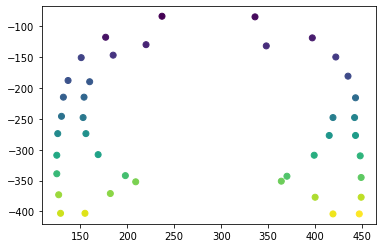

In [24]:
plt.scatter(px[:,0], -px[:,1],c=range(len(px)))

In [25]:
dx = np.array(((res.corners[2] - res.corners[1]) + (res.corners[3] - res.corners[0]))/12).T
dy = np.array(((res.corners[2] - res.corners[3]) + (res.corners[1] - res.corners[0]))/12).T
mat = np.vstack([dx, dy])

In [26]:
mat1 = np.linalg.inv(mat)

In [30]:
marker_points = []
det = np.linalg.det(mat1)
for point in px:
    kp = point.copy()
#     kp[0] -= int(res.center[0])
#     kp[1] -= int(res.center[1])
    p = [kp[0]*mat1[0, 0]+kp[1]*mat1[1, 0], kp[0]*mat1[0,1]+kp[1]*mat1[1,1]]
#     p = np.array([kp[0]*dy[1] - kp[1]*dy[0], -kp[0]*dx[1]+kp[1]*dx[0]])
#     p /= det
    
    marker_points.append(p)
marker_points = np.array(marker_points)

In [31]:
marker_points

array([[13.44653466,  4.59778251],
       [19.03773267,  4.58238536],
       [10.08402894,  6.57249161],
       [22.50799163,  6.4688622 ],
       [12.52125165,  7.22265078],
       [19.75080859,  7.24289992],
       [10.55765314,  8.21365129],
       [23.94309938,  8.21121136],
       [ 8.64071945,  8.4656153 ],
       [24.70057759,  9.96231082],
       [ 7.87805623, 10.57716017],
       [ 9.17835456, 10.67397449],
       [ 7.61607339, 12.11421361],
       [ 8.85839424, 12.09817138],
       [25.17872686, 11.94422772],
       [ 7.52651465, 13.87625095],
       [ 8.82681298, 13.97306527],
       [23.84760145, 13.77910016],
       [25.14639143, 13.76232874],
       [ 7.32175511, 15.46936807],
       [ 9.015829  , 15.4474923 ],
       [23.64359609, 15.42901015],
       [25.22473172, 15.40859276],
       [ 9.77556974, 17.36897037],
       [ 7.29168222, 17.4578477 ],
       [22.76422372, 17.25804905],
       [25.53196524, 17.2791115 ],
       [ 7.31430756, 19.16163379],
       [11.43881655,

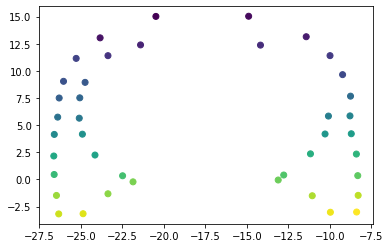

In [29]:
plt.scatter(marker_points[:, 0], -marker_points[:, 1], c=range(len(marker_points)))

In [35]:
draw_points_on_aruco(img, [res], marker_points, True)
cv2.waitKey(0)

[-4.15831482  3.98760244]


233

In [ ]:
import annotation_utils
def draw_bbox_by_points(img, 
                        res, 
                        points=annotation_utils.get_points_from_CAD(),
                        show=False):
    new_points = annotation_utils.get_keypoints_on_image(img, points, camera_params)
    top = new_points[:, 0].min()
    bottom = new_points[:, 0].max()
    left = new_points[:, 1].min()
    right = new_points[:, 1].max()
    bbox_corners = np.array([
        [top, left],
        [top, right],
        [bottom, right],
        [bottom, left],
    ])
    if show:
        imgc = img.copy()
        cv2.line(imgc, bbox_corners[0], bbox_corners[1], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[1], bbox_corners[2], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[2], bbox_corners[3], (0,255,0), 1)
        cv2.line(imgc, bbox_corners[3], bbox_corners[-1], (0,255,0), 1)
        cv2.imshow('draw_bbox_by_points', imgc)
        cv2.waitKey(0)
    return bbox_corners

In [ ]:
img = cv2.imread('/home/viacheslav/jupyter_notebooks/data/far_photos/20.jpg')
res = annotation_utils.detect_apriltag('/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/20.jpg', camera_params)
draw_bbox_by_points(img, res, show=True)

### get robot poses

In [19]:
inserted_j = ur10.getj()
inserted_l = ur10.getl()
print(inserted_j)
print(inserted_l)

[-4.998593632374899, -1.644775692616598, 1.8084745407104492, 6.020843982696533, -0.2982600370990198, 0.12933599948883057]
[0.10536873297868135, -0.5533021313854405, 0.5293912901803394, 1.242622745104883, 1.2236036661373513, 1.2353460642122878]


In [17]:
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01692471,  0.02372329,  0.99957529],
       [ 0.99930341, -0.03285447,  0.01769985],
       [ 0.03326042,  0.99917856, -0.02315071]])>
<Vector: (0.60532, -0.55332, 0.52937)>
>

In [23]:
zero_pose_l = ur10.getl()
zero_pose_j = ur10.getj()
print(zero_pose_l)
print(zero_pose_j)

[0.6053518982089526, -0.553289395354214, 0.5294081583380398, 1.2425986747757027, 1.2235478703363973, 1.2352977113830281]
[-4.190050188695089, -1.1814973990069788, 1.6938786506652832, -3.591449562703268, -0.5103328863727015, 3.1160995960235596]


In [22]:
zero_pose_l = [0.6053738400708184,
 -0.5532917677103614,
 0.5293931050569378,
 1.242668373605403,
 1.2235408761040583,
 1.2353307425198223] # 15 cm from socket
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01706775,  0.02374694,  0.9995723 ],
       [ 0.99929951, -0.03289479,  0.01784458],
       [ 0.03330447,  0.99917667, -0.02316886]])>
<Vector: (0.60534, -0.55326, 0.52940)>
>

In [24]:
ur10.movel([zero_pose_l[0]-0.5, *zero_pose_l[1:]], vel=1)
# ur10.movej([zero_pose_l[0]-0.5, *zero_pose_l[1:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01703289,  0.02371058,  0.99957375],
       [ 0.99930309, -0.03280647,  0.01780647],
       [ 0.03321468,  0.99918044, -0.02313527]])>
<Vector: (0.10543, -0.55330, 0.52943)>
>

In [25]:
far_pose_l = ur10.getl()
far_pose_j = ur10.getj()
print(far_pose_l)
print(far_pose_l)

[0.10533391941557418, -0.5533141430155365, 0.5294019637203735, 1.2425500025074443, 1.2235740688727648, 1.2352615419888655]
[0.10533391941557418, -0.5533141430155365, 0.5294019637203735, 1.2425500025074443, 1.2235740688727648, 1.2352615419888655]


In [49]:
x_far = [0, .25]
y_far = [-.25, .25]
z_far = [-.2, .2]

In [33]:
x_close = [-.1, -.25]
y_close = [-.10, .10]
z_close = [-.15, .05]

In [56]:
ur10.movel([far_pose_l[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[1], 
            *far_pose_l[3:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01701676,  0.02369183,  0.99957447],
       [ 0.99931074, -0.03258451,  0.01778459],
       [ 0.032992  ,  0.99918814, -0.02312102]])>
<Vector: (0.10529, -0.80325, 0.72944)>
>

In [38]:
ur10.movel(zero_pose_l)

<Transform:
<Orientation: 
array([[-0.01703297,  0.02372357,  0.99957344],
       [ 0.9993023 , -0.03282982,  0.01780752],
       [ 0.03323827,  0.99917936, -0.02314783]])>
<Vector: (0.60529, -0.55332, 0.52938)>
>

In [51]:
ur10.movel([zero_pose_l[0]+x_close[0], zero_pose_l[1]+y_close[0], zero_pose_l[2]+z_close[1], 
            *zero_pose_l[3:]], vel=1)

<Transform:
<Orientation: 
array([[-0.01698808,  0.02366321,  0.99957564],
       [ 0.99930719, -0.0327077 ,  0.01775781],
       [ 0.03311403,  0.9991848 , -0.02309118]])>
<Vector: (0.50529, -0.65325, 0.57944)>
>

In [27]:
R.from_rotvec([ 1.2186813991654113,
 1.2029606765250755,
 1.1943521654058413]).as_rotvec()

array([1.2186814 , 1.20296068, 1.19435217])

In [28]:
from scipy.spatial.transform import Rotation as R

# angles along X and Y
orients = np.array([
#         [-5, -5],
    [-5, 0],
#     [-5, 5],
#     [0,  -5],
    [0,  0],
#     [0,  5],
#     [5,  -5],
    [5,  0],
#     [5, 5]
], dtype=float)

# orients *= np.pi/180
rotations = [R.from_euler('xy', x, degrees=True) for x in orients]

In [29]:
r0 = rotations[0]
r0.as_matrix()

array([[ 1.        , -0.        ,  0.        ],
       [ 0.        ,  0.9961947 ,  0.08715574],
       [-0.        , -0.08715574,  0.9961947 ]])

In [30]:
r0.apply(lrc[3:])

array([1.21886184, 1.30249854, 1.0851754 ])

In [224]:
  img_coords = {}

In [225]:
img_coords

{}

In [237]:
ur10.movel(zero_pose)

<Transform:
<Orientation: 
array([[ 0.01497981,  0.00522241,  0.99987416],
       [ 0.99988605,  0.00179294, -0.01498936],
       [-0.00187099,  0.99998476, -0.00519496]])>
<Vector: (0.54892, -0.54403, 0.40710)>
>

In [219]:
llc

[0.5489486179287019,
 -0.4439867205295215,
 0.30719103192310093,
 1.218738328932778,
 1.2028588706030305,
 1.1943576930489765]

## Record points with aruco on socket

In [50]:
ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[1], 
            *far_pose_l[3:]])
#            , vel=1)
# ur10.movel(far_pose_l)

<Transform:
<Orientation: 
array([[-0.0170399 ,  0.02367616,  0.99957445],
       [ 0.99930489, -0.03274923,  0.01781101],
       [ 0.03315699,  0.99918313, -0.02310166]])>
<Vector: (0.10531, -0.80327, 0.72941)>
>

In [34]:
img_coords = [0]*2000
!rm data/points/*
!rm data/no_points/*

rm: cannot remove 'data/points/*': No such file or directory
rm: cannot remove 'data/no_points/*': No such file or directory


In [62]:
ur10.movel(lrf, vel=1., acc=1.)

<Transform:
<Orientation: 
array([[ 0.01476259,  0.00531222,  0.99987692],
       [ 0.99988992,  0.00140731, -0.01477026],
       [-0.0014856 ,  0.9999849 , -0.00529086]])>
<Vector: (0.44891, -0.64389, 0.30712)>
>

In [73]:
img_coords = [0]*600
# delta = .05
img_name = -1
js = []
# ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[0], 
#             *far_pose_l[3:]], vel=1)
pose = zero_pose_l.copy()
# i, j, k = 0,0,0
# these ranges for far
# xrange = [0, .05, .1, .15, .2, .25]
# yrange = [-.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25]
# zrange = [-.2, -.15, -.1, -.05, 0, .05, .1, .15, .2] 

#these for close
xrange = [-.1, -.125, -.15, -.175, -.2, -.225, -.25]
yrange = [-.1, -.075, -.05, -.025, 0, .025, .05, .1, ]
zrange = [-.15, -.1, -.05, 0, .05,] 

from itertools import product
poss = list(product(*[xrange, yrange, zrange]))

for pos in poss:
#     print(pose, pos)
    ur10.movel([pose[0]+pos[0], pose[1]+pos[1], pose[2]+pos[2], *pose[3:]])
#             pose = [pose[0]+delta*i, pose[1]+delta*j, pose[2]+delta*k, *pose[3:]]
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos/{img_name}.jpg',
            img)
    js.append(ur10.getj())
            
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/far_photos_joints.json', 'w'))

In [95]:
ur10.movel(far_pose_l, vel=1)

<Transform:
<Orientation: 
array([[-0.01719527,  0.02371831,  0.99957079],
       [ 0.99930165, -0.0327621 ,  0.01796803],
       [ 0.03317421,  0.99918171, -0.02313839]])>
<Vector: (0.10537, -0.55328, 0.52940)>
>

In [ ]:
img_name = -1
for posej in tqdm(js):
    ur10.movej(posej)
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/{img_name}.jpg',
            img)

 82%|████████▏ | 486/594 [34:26<05:49,  3.24s/it]  

In [72]:
img_coords = [0]*600
delta = .05
img_name = -1
js = []
ur10.movel([far_pose_l[0]+x_far[0], far_pose_l[1]+y_far[0], far_pose_l[2]+z_far[0], 
            *far_pose_l[3:]], vel=1)
for i in range(6):
    for j in tqdm(range(11)):
        for k in range(7):
            for l in range(len(rotations)):
                pose = [lrf[0]+delta*i, lrf[1]+delta*j, lrf[2]+delta*k, *lrf[3:]]
                d_angle = orients[l]
                
                init_rotvec = lrc[3:]
                matrix = R.from_rotvec(init_rotvec).as_matrix()
                pose[3:] = R.from_matrix(rotations[l].apply(matrix)).as_rotvec()
                
                ur10.movel(pose, vel=1)
            
                img = get_photo_from_realsense()
                
                cv2.imwrite(
                    f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2/{img_name}.jpg',
                    img)

#                 res = detect_apriltag(img)

#                 if res: 
#                     img_w, desired_corners = warp_img(img, res)

#                     res_warp = detect_apriltag(img_w)
#                     if res_warp:
#                         img_name += 1
#                         center, points_w = draw_points_on_aruco(img_w, res_warp, seventeen_points, False)

#                         inv_project = get_projection(res[0].corners, desired_corners)
#                         img_ok = warp(img_w, inv_project)
#                         points = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in points_w])
            
#                         center, points = draw_points_on_aruco(img, res, seventeen_points, True)

#                         img_coords[img_name] = points
#                         js.append(ur10.getj())
                
                        

# json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen_2.json', 'w'))
# json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2.json', 'w'))

100%|██████████████████████████████████████████| 11/11 [40:43<00:00, 222.12s/it]


In [ ]:
img_name = -1
for posej in tqdm(js):
    ur10.movej(posej)
    img_name +=1
    img = get_photo_from_realsense()
    cv2.imshow('robot sees', img)
    cv2.waitKey(1)
    cv2.imwrite(
            f'/home/viacheslav/jupyter_notebooks/data/far_photos_with_marker/{img_name}.jpg',
            img)

In [ ]:
json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen_2.json', 'w'))
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_2.json', 'w'))

In [60]:
img_coords = [0]*2000

for i, posej in enumerate(js):
    ur10.movej(posej, vel=1, acc=1)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
            
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)

    img_coords[i] = points
    
    
with open('img_coords.pickle', 'wb') as handle:
    pkl.dump(img_coords, handle, protocol=pkl.HIGHEST_PROTOCOL)

TypeError: 'NoneType' object is not subscriptable

In [69]:

with open('img_coords.pickle', 'wb') as handle:
    pkl.dump(img_coords, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
# with open('js.pickle', 'wb') as handle:
#     pkl.dump(js, handle, protocol=pkl.HIGHEST_PROTOCOL)

Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False, 'robotMode': 4, 'controlMode': 0, 'speedFraction': 1.0, 'speedScaling': 0.0, 'speedFractionLimit': 63}
Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False, 'robotMode': 4, 'controlMode': 0, 'speedFraction': 1.0, 'speedScaling': 0.0, 'speedFractionLimit': 63}
Robot not running: {'size': 47, 'type': 0, 'timestamp': 39658016000, 'isPhysicalRobotConnected': True, 'isRealRobotEnabled': True, 'isPowerOnRobot': True, 'isEmergencyStopped': False, 'isSecurityStopped': False, 'isProgramRunning': False, 'isProgramPaused': False,

In [1]:

# approved by Viktor
def draw_points_on_aruco(img, res, changes=None, show=False):
    dx = (res[0].corners[2] - res[0].corners[1])/6
    dy = (res[0].corners[2] - res[0].corners[3])/6
    print (dx*dy)
    
    if changes is None:
        changes = np.array([
            [0, 0],
            [3, 1],
            [2, 2],
            [-2, 2],
            [-3, 1],
            [-3, -1],
            [-2, -3],
            [2, -3],
            [3, -1]
        ])
        
    points = np.zeros((changes.shape[0], 2), dtype=float)
    for i, ch in enumerate(changes):
        points[i] = [ch[0]*dx[0]+ch[1]*dy[0], ch[0]*dx[1]+ch[1]*dy[1]]
        
    points[:, 0] += sum([x[0] for x in res[0].corners])/4
    points[:, 1] += sum([x[1] for x in res[0].corners])/4
    
    if show:
#         draw_corners(img, res[0])
        for p in points:
            kp = int(p[0]), int(p[1])
            cv2.circle(img, kp, 2, (0, 0, 255), -1)
        cv2.imshow('draw_points_on_aruco', img)
        cv2.waitKey(1)
    return points[0], points[1:]

def warp_img(image, res):
    corners = res[0].corners
    
    corners[:2] = np.array(sorted(corners[:2], key=lambda x: x[1]))
    corners[2:] = np.array(sorted(corners[2:], key=lambda x: x[1]))

    a = corners[:2][:, 0].mean()
    c = corners[2:][:, 0].mean()
    b = corners[::2][:, 1].mean()
    d = corners[1::2][:, 1].mean()

    desired_corners = np.array([[a, b], [a, d], [c, b], [c, d]], dtype=int)

    tform = get_projection(desired_corners, corners)
    image_warped = warp(image, tform)
    return image_warped, desired_corners, tform

def draw_corners(img, r, show=False):
    if isinstance(r, np.ndarray):
        imagePoints = [r]
    else:
        imagePoints = r.corners.reshape(1,4,2)
    
    for corner in range(np.size(imagePoints[0],axis=0)):
        center = ((int(imagePoints[0][corner][0]),int(imagePoints[0][corner][1])))
        cv2.circle(img, center, 3, (0,0,255), -1)
    
    if show:
        cv2.imshow('img', color_image)
    return imagePoints[0]

In [ ]:
def draw_corners(img, r, show=False):
    if isinstance(r, np.ndarray):
        imagePoints = [r]
    else:
        imagePoints = r.corners.reshape(1,4,2)
    
    for corner in range(np.size(imagePoints[0],axis=0)):
        center = ((int(imagePoints[0][corner][0]),int(imagePoints[0][corner][1])))
        cv2.circle(img, center, 3, (0,0,255), -1)
    
    if show:
        cv2.imshow('img', img)
        cv2.waitKey(0)
    return imagePoints[0]

In [62]:
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()
# buf_sz = 10
# buffer = np.zeros((buf_sz, 17, 3), dtype=float)
# index = 0
while True:
    index += 1
    index = index % buf_sz
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    cv2.imshow('original', img)
    cv2.waitKey(1)
    if res: 
        img_w, desired_corners,tform = warp_img(img, res)
#         desired corners are int!
#         print("desired_corners",desired_corners)
        
        res_warp = detect_apriltag(img_w)
        if res_warp:
            center, points_w = draw_points_on_aruco(img_w, res_warp, seventeen_points, True)
#             corners_w = draw_corners(img_w, res_warp[0], False)
            inv_project = get_projection(res[0].corners, desired_corners)
#             print(inv_project)
            str_project = get_projection(desired_corners, res[0].corners)
            img_ok = warp(img_w, inv_project)
            
#             points = [np.linalg.inv(tform.params) @ np.array([p[0], p[1], 1]) for p in points_w]
            points = [str_project.params @ np.array([p[0], p[1], 1]) for p in points_w]

            for p in points:
                p/= p[2]
            points = np.array(points)
            
#             points = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in points_w])
#             buffer[index] = points
#             corners = np.array([inv_project.params @ np.array([p[0], p[1], 1]) for p in corners_w])
#             print('corners', corners)
#             for p in np.mean(buffer, axis=0):
#                 kp = int(p[0]), int(p[1])
#                 cv2.circle(img_ok, kp, 2, (0,255, 255), -1)
            for c in points:
                kc = int(c[0]), int(c[1])
                cv2.circle(img, kc, 3, (0,255, 255), -1)
            cv2.imshow('final', img)
#             cv2.waitKey(10)
#             center, points = draw_points_on_aruco(img, res, seventeen_points, True)

## Save data

In [57]:
json.dump(img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen.json', 'w'))
json.dump(js, open(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos.json', 'w'))

## Get photos

In [67]:
coords_j = json.load(open('/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos.json'))
print('data len', len(coords_j))
for i, position in tqdm(enumerate(coords_j)):
    ur10.movej(position, vel=1, acc=1)
    img = get_photo_from_realsense()
    cv2.imwrite(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_17/{i}.png', img)

483it [08:53,  1.10s/it]


In [235]:
json.dump( img_coords, open(f'/home/viacheslav/jupyter_notebooks/data/seventeen.json', 'w'))

In [58]:
ur10.movej([-4.250930611287252, -0.8361623922931116, 1.6090149879455566, 2.2111873626708984, -0.48303395906557256, 3.2748172283172607],)

[-4.250751320515768,
 -0.8363898436175745,
 1.6091465950012207,
 2.211355209350586,
 -0.4832256476031702,
 3.274637460708618]

In [294]:

llc_points = []
lrc_points = []
for _ in range(10):
    ur10.movel(llc)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)
    lrc_points.append(points)
    ur10.movel(lrc)
    img = get_photo_from_realsense()
    res = detect_apriltag(img)
    center, points = draw_points_on_aruco(img, res, seventeen_points, True)
    llc_points.append(points)

In [70]:
points

[[141.2156620025635, 31.427259445190458],
 [235.98294258117676, 30.749380111694364],
 [94.27264328002933, 93.3649314880371],
 [165.34810371398927, 92.85652198791504],
 [212.7317440032959, 92.517582321167],
 [283.80720443725585, 92.00917282104494],
 [47.09236679077151, 122.13405532836914],
 [141.8596473693848, 121.45617599487306],
 [236.62692794799804, 120.77829666137698],
 [331.3942085266113, 120.1004173278809],
 [94.8149467468262, 169.17875595092772],
 [151.67531509399416, 168.77202835083008],
 [222.7507755279541, 168.26361885070804],
 [284.3495079040527, 167.82299728393556],
 [185.08112106323244, 201.70331878662105],
 [114.31070632934569, 244.85700454711912],
 [265.9383552551269, 243.77239761352536]]

In [197]:
cv2.destroyAllWindows()

In [ ]:

points = json.load(open('/home/viacheslav/jupyter_notebooks/data/seventeen.json'))
# cv2.imshow('img', img)
# cv2.waitKey(0)
for i in range(len(points)): 
    img = cv2.imread(f'/home/viacheslav/jupyter_notebooks/data/joint_coords_for_photos_17/{i}.png')    
    draw_points(img, points[i], True, True)

In [19]:
pose = ur10.getj()

In [57]:
ur10.movej(pose)

[-4.138930384312765,
 -1.0015667120562952,
 1.7134833335876465,
 -3.7953017393695276,
 -0.5600474516498011,
 3.1207034587860107]

# Robot sees

## Get nice graphs

# Record points